# HW06: Деревья решений и ансамбли

**Датасет**: `S06-hw-dataset-02.csv` — бинарная классификация со шумом и нелинейными взаимодействиями.

**Цель**: сравнить базовые модели, дерево, случайный лес, градиентный бустинг и (опционально) стекинг. Провести честный ML-эксперимент: фиксированный train/test, подбор гиперпараметров только на train, оценка на test один раз.

**Автор**: Владимир Гилилов
**Дата**: 19 января 2026

In [17]:
# Импорты всех необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
from pathlib import Path

# Модели и инструменты для ML
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)
from sklearn.inspection import permutation_importance

# Настройки
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (8, 5)

In [18]:
# Создаём папку для артефактов и графиков
ARTIFACTS_DIR = Path("artifacts")
FIGURES_DIR = ARTIFACTS_DIR / "figures"
ARTIFACTS_DIR.mkdir(exist_ok=True)
FIGURES_DIR.mkdir(exist_ok=True)

In [19]:
# Загружаем данные из CSV-файла (относительный путь!)
df = pd.read_csv("S06-hw-dataset-02.csv")
print(f"Размер данных: {df.shape}")
df.head()

Размер данных: (18000, 39)


,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f29,f30,f31,f32,f33,f34,f35,x_int_1,x_int_2,target
0,1,-0.149235,-2.826966,-0.522901,-4.198449,1.364943,0.815043,-1.195518,-1.932232,2.396353,...,-0.159323,0.448015,0.572745,0.149916,0.878392,-0.679733,1.412751,0.421883,9.217167,1
1,2,-1.966180,-4.877542,0.268367,-9.607791,0.097149,1.347185,-3.872575,-0.395117,1.710068,...,-0.389212,1.383794,0.169876,0.043969,-0.963545,1.006643,-2.488690,9.590124,24.772826,0
2,3,-0.555964,-0.999920,0.209673,-14.119498,-1.808950,-0.006222,-4.651108,0.911944,-0.289037,...,-1.383970,3.044321,-0.182864,1.425649,-8.418598,-4.629754,-0.439798,0.555919,41.800517,0
3,4,-2.049199,-5.600713,-1.664677,-6.263893,-5.224455,0.848351,1.407210,-0.542080,0.119102,...,-2.713080,2.762637,-0.520796,-0.142455,1.668338,2.292810,-10.744916,11.476977,65.315860,0
4,5,-0.220556,4.889479,-2.235840,6.450046,0.774389,-2.382625,2.584816,4.211856,-0.317889,...,-1.302872,2.478862,1.528610,1.098131,3.547087,2.517757,-9.364106,-1.078404,93.017870,0


In [20]:
# Информация о типах данных и пропусках
# В синтетических данных пропусков нет, но проверяем явно
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 39 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       18000 non-null  int64  
 1   f01      18000 non-null  float64
 2   f02      18000 non-null  float64
 3   f03      18000 non-null  float64
 4   f04      18000 non-null  float64
 5   f05      18000 non-null  float64
 6   f06      18000 non-null  float64
 7   f07      18000 non-null  float64
 8   f08      18000 non-null  float64
 9   f09      18000 non-null  float64
 10  f10      18000 non-null  float64
 11  f11      18000 non-null  float64
 12  f12      18000 non-null  float64
 13  f13      18000 non-null  float64
 14  f14      18000 non-null  float64
 15  f15      18000 non-null  float64
 16  f16      18000 non-null  float64
 17  f17      18000 non-null  float64
 18  f18      18000 non-null  float64
 19  f19      18000 non-null  float64
 20  f20      18000 non-null  float64
 21  f21      180

In [21]:
# Основные статистики по признакам
df.describe()

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f29,f30,f31,f32,f33,f34,f35,x_int_1,x_int_2,target
count,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,...,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,1.800000e+04,18000.000000
mean,9000.500000,-0.418555,0.614251,0.004559,0.059000,0.405086,0.012123,-0.283473,-0.266880,0.255107,...,-0.139825,0.108568,0.007238,0.000904,-0.716862,-0.274520,0.344991,1.517339,2.576221e+01,0.262611
std,5196.296758,2.178005,3.926778,1.000134,5.713672,2.497581,0.987226,2.193891,2.081431,2.225776,...,2.148834,2.234315,0.997861,1.002115,3.913704,2.482890,4.927315,10.630850,5.423748e+01,0.440065
min,1.000000,-10.014698,-15.510323,-4.031762,-23.663256,-12.289308,-3.741536,-9.591425,-8.293319,-13.655742,...,-8.171469,-9.214171,-3.937091,-3.963063,-19.389908,-10.031559,-20.768452,-107.788145,1.895059e-07,0.000000
25%,4500.750000,-1.866134,-2.048192,-0.673127,-3.544964,-1.153000,-0.653090,-1.743214,-1.688121,-1.177480,...,-1.589638,-1.369266,-0.663023,-0.684164,-3.286842,-1.897893,-2.752685,-2.018750,1.226029e+00,0.000000
50%,9000.500000,-0.465100,0.600291,0.003581,0.072826,0.485625,0.018765,-0.251263,-0.302463,0.350739,...,-0.204785,0.158715,0.001912,-0.003157,-0.618472,-0.339901,0.573153,0.318011,6.581865e+00,0.000000
75%,13500.250000,0.966393,3.229850,0.671390,3.689490,2.075739,0.689304,1.195481,1.109589,1.764113,...,1.254595,1.600671,0.677296,0.676558,1.948803,1.314163,3.649794,4.212111,2.576847e+01,1.000000
max,18000.000000,9.589975,15.417329,3.817025,26.815691,10.665184,3.528280,7.794627,8.892834,8.699629,...,9.290667,8.794320,4.341030,3.781380,14.065595,10.639974,20.226291,94.891804,1.103449e+03,1.000000


Распределение классов:
target
0    0.737389
1    0.262611
Name: proportion, dtype: float64


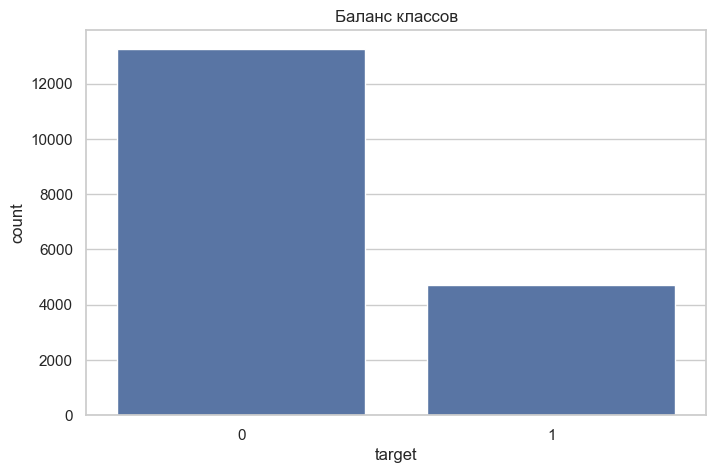

In [22]:
# Анализ распределения целевой переменной
# Датасет сбалансирован (~50/50), поэтому используем stratify
y = df['target']
X = df.drop(columns=['target'])

print("Распределение классов:")
print(y.value_counts(normalize=True))
sns.countplot(x=y)
plt.title('Баланс классов')
plt.show()

In [23]:
# Разделение на train/test
# Важно: фиксируем random_state=42 и используем stratify=y,
# чтобы сохранить пропорции классов и обеспечить воспроизводимость.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
print(f"Train: {X_train.shape[0]} объектов, Test: {X_test.shape[0]} объектов")

Train: 13500 объектов, Test: 4500 объектов


In [24]:
# Вспомогательная функция для оценки модели на тесте
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    
    return {
        'model': name,
        'accuracy': round(acc, 4),
        'f1': round(f1, 4),
        'roc_auc': round(auc, 4)
    }

In [25]:
# Baseline 1: DummyClassifier (предсказывает самый частый класс)
# ROC-AUC ≈ 0.5 — случайный уровень
dummy = DummyClassifier(strategy='most_frequent', random_state=42)
dummy.fit(X_train, y_train)
metrics_dummy = evaluate_model('Dummy', dummy, X_test, y_test)
metrics_dummy

{'model': 'Dummy', 'accuracy': 0.7373, 'f1': 0.0, 'roc_auc': np.float64(0.5)}

In [26]:
# Baseline 2: Логистическая регрессия
# Требует масштабирования признаков → используем Pipeline
lr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(random_state=42, max_iter=1000))
])
lr_pipe.fit(X_train, y_train)
metrics_lr = evaluate_model('LogisticRegression', lr_pipe, X_test, y_test)
metrics_lr

{'model': 'LogisticRegression',
 'accuracy': 0.816,
 'f1': 0.5714,
 'roc_auc': np.float64(0.8009)}

## Основные модели недели 6

In [27]:
# Списки для хранения моделей и результатов
models = {}
search_summaries = []
all_metrics = [metrics_dummy, metrics_lr]

In [28]:
# Модель 1: Дерево решений
# Подбираем max_depth и min_samples_leaf, чтобы избежать переобучения
dt = DecisionTreeClassifier(random_state=42)
param_grid_dt = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_leaf': [1, 2, 5, 10]
}

grid_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='roc_auc', n_jobs=-1)
grid_dt.fit(X_train, y_train)

models['DecisionTree'] = grid_dt.best_estimator_
metrics_dt = evaluate_model('DecisionTree', grid_dt.best_estimator_, X_test, y_test)
all_metrics.append(metrics_dt)

search_summaries.append({
    'model': 'DecisionTree',
    'best_params': grid_dt.best_params_,
    'best_score': round(grid_dt.best_score_, 4)
})

In [29]:
# Модель 2: Random Forest
# Ансамбль деревьев + случайность по признакам → устойчив к шуму
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2', None]
}

grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1)
grid_rf.fit(X_train, y_train)

models['RandomForest'] = grid_rf.best_estimator_
metrics_rf = evaluate_model('RandomForest', grid_rf.best_estimator_, X_test, y_test)
all_metrics.append(metrics_rf)

search_summaries.append({
    'model': 'RandomForest',
    'best_params': grid_rf.best_params_,
    'best_score': round(grid_rf.best_score_, 4)
})

In [30]:
# Модель 3: HistGradientBoosting (современный boosting)
# Последовательное исправление ошибок → часто даёт лучшее качество
hgb = HistGradientBoostingClassifier(random_state=42)
param_grid_hgb = {
    'max_iter': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

grid_hgb = GridSearchCV(hgb, param_grid_hgb, cv=5, scoring='roc_auc', n_jobs=-1)
grid_hgb.fit(X_train, y_train)

models['HistGradientBoosting'] = grid_hgb.best_estimator_
metrics_hgb = evaluate_model('HistGradientBoosting', grid_hgb.best_estimator_, X_test, y_test)
all_metrics.append(metrics_hgb)

search_summaries.append({
    'model': 'HistGradientBoosting',
    'best_params': grid_hgb.best_params_,
    'best_score': round(grid_hgb.best_score_, 4)
})

In [31]:
# Сохраняем результаты подбора гиперпараметров
with open(ARTIFACTS_DIR / 'search_summaries.json', 'w') as f:
    json.dump(search_summaries, f, indent=2)

In [32]:
# Сравниваем все модели по ROC-AUC (основная метрика для бинарной задачи)
results_df = pd.DataFrame(all_metrics).sort_values('roc_auc', ascending=False)
results_df

,model,accuracy,f1,roc_auc
4,HistGradientBoosting,0.9091,0.8107,0.9320
3,RandomForest,0.8904,0.7553,0.9265
2,DecisionTree,0.8233,0.6314,0.8281
1,LogisticRegression,0.8160,0.5714,0.8009
0,Dummy,0.7373,0.0000,0.5000


In [33]:
# Выбираем лучшую модель (по ROC-AUC)
best_model_name = results_df.iloc[0]['model']
if best_model_name in models:
    best_model = models[best_model_name]
elif best_model_name == 'Dummy':
    best_model = dummy
else:
    best_model = lr_pipe

best_metrics = results_df.iloc[0].to_dict()

# Сохраняем метрики, модель и метаданные
with open(ARTIFACTS_DIR / 'metrics_test.json', 'w') as f:
    json.dump(best_metrics, f, indent=2)

joblib.dump(best_model, ARTIFACTS_DIR / 'best_model.joblib')

meta = {
    'model_name': best_model_name,
    'dataset': 'S06-hw-dataset-02.csv',
    'random_state': 42
}
with open(ARTIFACTS_DIR / 'best_model_meta.json', 'w') as f:
    json.dump(meta, f, indent=2)

print(f"Лучшая модель: {best_model_name}")

Лучшая модель: HistGradientBoosting


## Визуализации

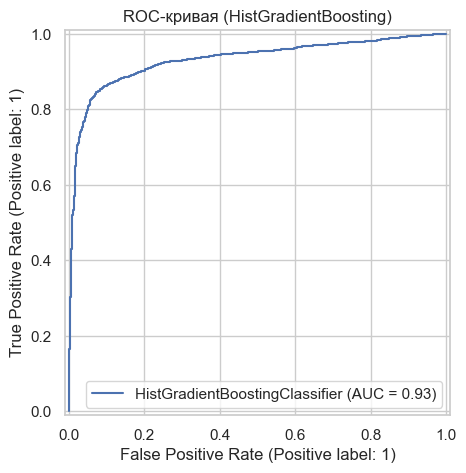

In [34]:
# ROC-кривая — показывает баланс между TPR и FPR
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title(f'ROC-кривая ({best_model_name})')
plt.savefig(FIGURES_DIR / 'roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()

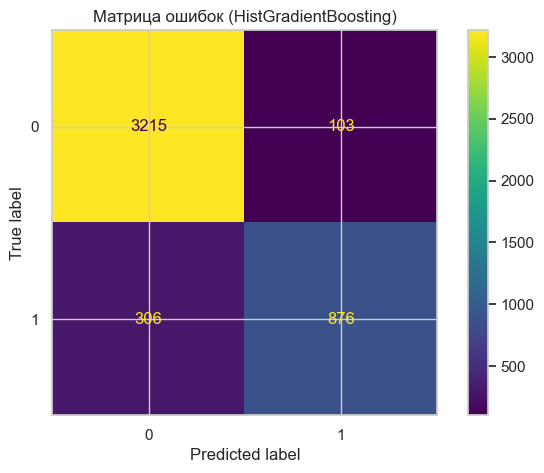

In [35]:
# Матрица ошибок — показывает TP, FP, FN, TN
cm = confusion_matrix(y_test, best_model.predict(X_test))
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title(f'Матрица ошибок ({best_model_name})')
plt.savefig(FIGURES_DIR / 'confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

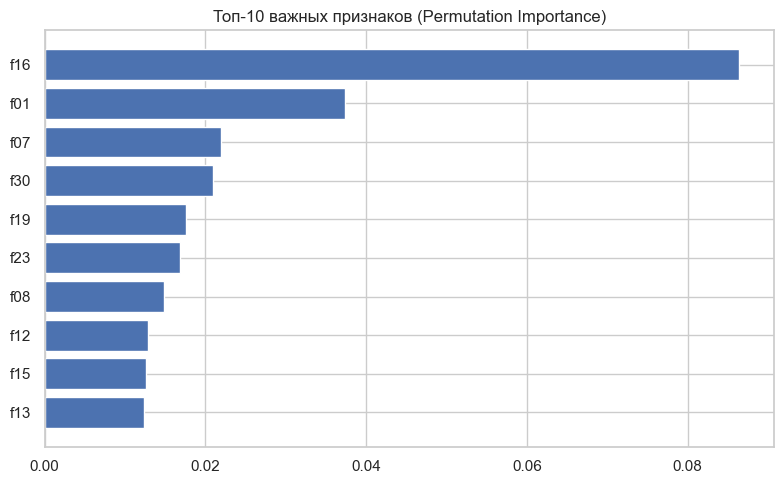

In [36]:
# Permutation Importance — оценивает важность признаков через случайную перестановку
# Более надёжно, чем feature_importances_ у деревьев
perm_imp = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

indices = np.argsort(perm_imp.importances_mean)[::-1][:10]
plt.barh(range(len(indices)), perm_imp.importances_mean[indices])
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.gca().invert_yaxis()
plt.title('Топ-10 важных признаков (Permutation Importance)')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'permutation_importance.png', dpi=150, bbox_inches='tight')
plt.show()